### Modelling

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from nltk.corpus import stopwords




In [2]:
combined = pd.read_csv('datasets/combined.csv')
combined.shape

(59129, 12)

In [3]:
# select X and y columns we need
df =  combined[['Subreddit', 'preprocessed_words']]

# add label for classification
df['is_amd'] = df['Subreddit'].apply(lambda x: 1 if x == "AMD" else 0)
df = df.drop(columns = 'Subreddit')
df = df.rename(columns={'preprocessed_words':'text'})

C:\Users\tiffa\AppData\Local\Temp\ipykernel_14272\3840046896.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_amd'] = df['Subreddit'].apply(lambda x: 1 if x == "AMD" else 0)


In [4]:
df.head()

,text,is_amd
0,keeps its price from the vram it has a is a ta...,0
1,it s not you just a combo of the game running ...,0
2,starfield is cpu heavy which one do you have a...,0
3,the game is just awfully optimized i just upgr...,0
4,i tried using fsr but i did nt see any noticib...,0


In [5]:
# Specify Stopwords
custom_stopwords = [ "subreddit", "reddit"]  # remove these words as it is not meaningful for our analysis
stopwords_list = list(set(stopwords.words('english') + custom_stopwords))

#### Baseline Model

In [6]:
# Baseline model
X = df['text']
y = df['is_amd']
y.value_counts(normalize=True)

is_amd
1    0.634545
0    0.365455
Name: proportion, dtype: float64

In [7]:
# Train Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify = y)
X_train = X_train.values.astype('U')
X_test = X_test.values.astype('U')
print(X_train.shape)
print(X_test.shape)

(47303,)
(11826,)


For this section on Modelling, I will only be considering the "text" column of the scraped dataset, and this has been pre-processed in notebook 2. This ensures that our model can be properly trained on the content of the subreddit posts.
I will be exploring different Classification algorithms and using both Count Vectorizer or Term Frequency-Inverse Document Frequency (TFIDF) transformers:
- Count Vectorizer: Takes every word as a token, and uses it as a feature.
- TFIFD: accounts for frequency of a word in a given document and the frequency between documents. Word importance increases proportionally to the number of times it appears in a document, but is offset by frequency of word in entire corpus.

#### Logistic Regression using *Count Vectorizer*

In [8]:
cvec = CountVectorizer(stop_words=stopwords_list)
cvec.fit(X_train)
X_train = cvec.transform(X_train) #transform the corpus

In [9]:
print(cvec.get_feature_names_out())
print(X_train.shape)

['aa' 'aaa' 'aaaaa' ... 'zx' 'zz' 'zzx']
(47303, 32124)


In [10]:
# Transform test
X_test = cvec.transform(X_test)

In [11]:
# Redefine train and test data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify = y)
X_train = X_train.values.astype('U')
X_test = X_test.values.astype('U')

In [12]:
# Setting up cvec pipeline

cvec_pipeline = Pipeline([("cvec", CountVectorizer(stop_words=stopwords_list)), 
                         ("log_reg", LogisticRegression())])

# Corrected CVEC hyperparameters
cvec_pipe_params = {
    "cvec__max_features": [100, 150, 200],  # A list of max_features values to try
    'cvec__min_df': [2,3],                  # no. of times the word/token has to appear in n-documents
    'cvec__max_df': [0.2,0.3,0.4],          # ignore words that appear in n% or more documents
    'cvec__ngram_range': [(1, 1), (1, 2)],
    
}

# Corrected GridSearchCV instantiation
cvec_lr_gs = GridSearchCV(cvec_pipeline, 
                          param_grid=cvec_pipe_params,
                          cv=5,
                          n_jobs=-1)

# Fitting the model to the training data
cvec_lr_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('log_reg', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.2, 0.3, 0.4],
                         'cvec__max_features': [100, 150, 200],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [43]:
# Get predictions
preds = cvec_lr_gs.predict(X_test)

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
cm = confusion_matrix(y_test, preds)
tn, fp, fn, tp = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
acc = (tp + tn)/ (tp+tn+fp+fn)
spec = tn / (tn + fp)


In [60]:
results_df = []

lr_cvec_results = {
    'Model': "Logistic Regression",
    'Vectorizer': "CVEC",
    'Train Score': cvec_lr_gs.score(X_train, y_train),
    'Test Score': cvec_lr_gs.score(X_test, y_test),
    'Accuracy': acc,
    'Specificity': spec
    
}

# Create a DataFrame from the dictionary
results_df.append(lr_cvec_results)


In [26]:
cvec_lr_gs.best_params_

{'cvec__max_df': 0.4,
 'cvec__max_features': 200,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

#### 2.2 Logistic Regression using *TFIFD Vectorizer*

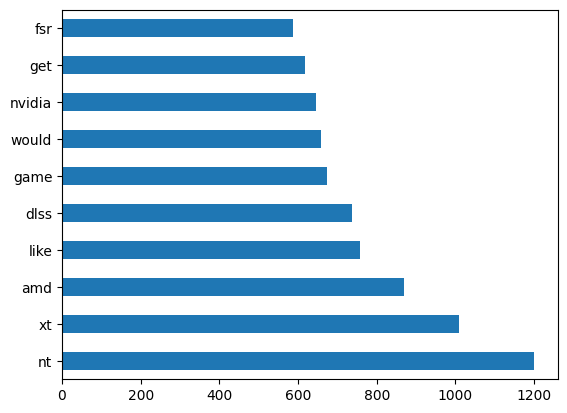

In [29]:
# Instantiate and fit the transformer.
tvec = TfidfVectorizer(stop_words=stopwords_list)

# convert training data to dataframe
X_train_df = pd.DataFrame(tvec.fit_transform(X_train).todense(), 
                          columns=tvec.get_feature_names_out())
# plot top words in terms of Tfidf score
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');

In [31]:
# Set up a pipeline with tf-idf vectorizer and logistic regression

pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=stopwords_list)),
    ('logreg', LogisticRegression())
])


pipe_tvec_params = {
    'tvec__max_features': [100,125],
    'tvec__ngram_range': [(1,1), (1,2)]
}


tvec_lr_gs = GridSearchCV(pipe_tvec, 
                        param_grid = pipe_tvec_params, 
                        cv=5,
                        n_jobs=-1) 

tvec_lr_gs.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logreg', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'tvec__max_features': [100, 125],
                         'tvec__ngram_range': [(1, 1), (1, 2)]})

In [47]:
# Get predictions
preds = tvec_lr_gs.predict(X_test)

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
cm = confusion_matrix(y_test, preds)
tn, fp, fn, tp = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
acc = (tp + tn)/ (tp+tn+fp+fn)
spec = tn / (tn + fp)



,Model,Vectorizer,Train Score,Test Score,Accuracy,Specificity,F1 Score
0,Logistic Regression,TVEC,0.672114,0.670726,0.670726,0.217955,0.787568


In [61]:
lr_tvec_results = {
    'Model': "Logistic Regression",
    'Vectorizer': "TVEC",
    'Train Score': tvec_lr_gs.score(X_train, y_train),
    'Test Score': tvec_lr_gs.score(X_test, y_test),
    'Accuracy': acc,
    'Specificity': spec,
    'F1 Score': f1_score
}

results_df.append(lr_tvec_results)
pd.DataFrame(results_df)


,Model,Vectorizer,Train Score,Test Score,Accuracy,Specificity,F1 Score
0,Logistic Regression,CVEC,0.680676,0.681549,0.670726,0.217955,NaN
1,Logistic Regression,TVEC,0.672114,0.670726,0.670726,0.217955,0.787568


#### 3.1 Random Forest using *Count Vectorizer*

In [67]:
pipe_cvec = Pipeline([
    ('cvec', CountVectorizer(stop_words=stopwords_list)),
    ('rf', RandomForestClassifier(random_state=123))
])

# Search over the following values of hyperparameters
pipe_cvec_params = {
    'cvec__max_features': [100, 200, 300],
    'cvec__max_df': [0.2, 0.3, 0.4],
    'cvec__min_df': [1, 2, 3],
    'cvec__ngram_range': [(1,1), (1,2)],
    'rf__n_estimators': range(50,100,10),
    'rf__criterion': ['gini', 'entropy']
}

cvec_rf_gs = GridSearchCV(pipe_cvec, 
                        param_grid = pipe_cvec_params, 
                        cv=3,
                        verbose=True,
                        n_jobs=-1,
                        ) 

cvec_rf_gs.fit(X_train, y_train)

Fitting 3 folds for each of 540 candidates, totalling 1620 fits


MemoryError: Unable to allocate 796. MiB for an array with shape (31535,) and data type <U6616

#### 3.2 Random Forest using *TFIFD Vectorizer*

In [ ]:
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=stopwords_list)),
    ('rf', RandomForestClassifier(random_state=123))
])

# Search over the following values of hyperparameters
pipe_tvec_params = {
    'tvec__max_features': [100, 200, 300],
    'tvec__max_df': [0.2, 0.3, 0.4],
    'tvec__min_df': [1, 2, 3],
    'tvec__ngram_range': [(1,1), (1,2)],
    'rf__n_estimators': range(50,100,10),
    'rf__criterion': ['gini', 'entropy']
}

tvec_rf_gs = GridSearchCV(pipe_cvec, 
                        param_grid = pipe_cvec_params, 
                        cv=5,
                        verbose=True,
                        n_jobs=-1,
                        ) 

tvec_rf_gs.fit(X_train, y_train)

#### 4.1 KNN using *Count Vectorizer*

In [ ]:
pipe_cvec = Pipeline([
    ('cvec', CountVectorizer(stop_words=stopwords_list)),
    ('knn', KNeighborsClassifier(random_state=123))
])

# Search over the following values of hyperparameters
pipe_cvec_params = {
    'cvec__max_features': [100, 200, 300],
    'cvec__max_df': [0.4, 0.6, 0.9],
    'cvec__min_df': [1, 2, 3],
    'cvec__ngram_range': [(1,1), (1,2)],
    'knn_n_neighbors': range(1,50,10),
    'knn_metric': ['euclidean', 'manhattan']
}

cvec_knn_gs = GridSearchCV(pipe_cvec, 
                        param_grid = pipe_cvec_params, 
                        cv=5,
                        verbose=True,
                        n_jobs=-1,
                        ) 

cvec_knn_gs.fit(X_train, y_train)

#### 4.2 KNN using *TFIFD Vectorizer*